<a href="https://colab.research.google.com/github/rb58853/images_RIS-ML-Conv-NLP/blob/main/end_model/caption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 115.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 92.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 44.1 MB/s eta 0:00:00


## Import librarys

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

### Load Image

In [46]:
img_url = '/content/1.jpg'
raw_image = Image.open(img_url).convert("RGB")
image = cv2.imread(img_url)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_partition = 64 #tamanno maximo de un cuadro de segmentacion = tamanno(imagen)/image_partition

# Load all Models

## Segment Anything Model

In [4]:
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

PyTorch version: 2.1.0+cu118
Torchvision version: 0.16.0+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-4xkgsqyq
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-4xkgsqyq
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=0df2112148ed3c5b9b7bf94ff70514b89bb085d6e9b95bf864f693cb2c6c5f3a
  Stored in directory: /tmp/pip-ephem-wheel-cache-nxt0xj1n/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-10-27 19:40:09--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.84.251.15, 52.84.251.106, 5

#### Create image from mask

In [5]:
from PIL import Image

def mask_image(mask, raw_image):
    weigth, heigth = raw_image.size
    new_image = Image.new('RGBA', (weigth, heigth), (0, 0, 0, 0))

    original_pixles = raw_image.load()
    pixels = new_image.load()

    for i in range (heigth):
        for j in range (weigth):
            if mask[i,j]:
                pixels[j, i] = original_pixles[j,i]
            else:
                pass
    return new_image

def bbox_image(bbox, image):
    x,y,w,h =  bbox[0],bbox[1],bbox[2],bbox[3]
    return image[y:y+h, x:x+w]

In [26]:
def all_areas_from_image(image, raw_image, min_area = 0, min_box_area = 0):
    masks = mask_generator_2.generate(image)
    images_box= []
    images_mask= []
    for mask in masks:
        box_im = bbox_image(mask['bbox'],image)
        h, w, c = box_im.shape
        box_area = h * w
        if mask['area'] >= min_area and box_area >= min_box_area:
            images_box.append(box_im)
            images_mask.append(mask_image(mask['segmentation'], raw_image))
    return {'box':images_box, 'mask':images_mask}

## BLIP

In [7]:
from transformers import BlipProcessor, BlipForConditionalGeneration

blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large").to("cuda")

In [29]:
def blip (_image):
    inputs = blip_processor(_image, return_tensors="pt").to("cuda")
    out = blip_model.generate(**inputs)
    result = blip_processor.decode(out[0], skip_special_tokens=True)

    if result[:9] == "there is ":
        result = result[9:]

    return result

def all_captions(image, raw_image, segmentation = 'box', min_area = 1, min_box_area = 0):
    areas = all_areas_from_image(image, raw_image, min_area,min_box_area)[segmentation]
    origin = str(blip(raw_image))
    captions = [origin]
    for im in areas:
        captions.append(origin +" "+ str(blip(im)))
    return captions

## CLIP

In [9]:
from transformers import CLIPProcessor, CLIPModel

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
clip_model = clip_model.to(device)

In [10]:
def select_caption(captions, image):
    inputs = clip_processor(text=captions, images=image, return_tensors="pt", padding=True)
    inputs = {name: tensor.to(device) for name, tensor in inputs.items()}
    outputs = clip_model(**inputs)

    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1)
    return {'caption':select_from_probs(probs, captions), 'probs': probs[0]}

def select_from_probs(probs, captions):
    max_prob = 0
    index = 0
    for i,prob in zip(range(len(probs[0])),probs[0]):
        if prob > max_prob:
            max_prob = prob
            index = i
    return captions[index]

def reduce_caption(caption, image):
    split = caption.split(' ')
    for word in split:
        temp = caption.split(' ')
        temp.remove(word)
        temp = ' '.join(temp)

        inputs = clip_processor(text=[temp, caption], images=image, return_tensors="pt", padding=True)
        inputs = {name: tensor.to(device) for name, tensor in inputs.items()}
        outputs = clip_model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)

        if probs[0][0]> probs[0][1]:
            caption = temp


    return caption

# Run Model

In [22]:
def short_captions(probs,captions):
    _probs = [prob.item() for prob in probs]
    for i in range(len(captions)):
        for j in range(i+1, len(captions)):
            if _probs[j]>_probs[i]:
                temp_p= _probs[i]
                temp_c = captions[i]
                _probs[i] = _probs[j]
                captions[i] = captions[j]
                _probs[j] = temp_p
                captions[j] = temp_c
    return {prob: caption for prob,caption in zip(_probs,captions) }

In [47]:
weigth, heigth = raw_image.size
area = (weigth * heigth)/image_partition
captions = all_captions(image, raw_image, min_box_area = area)

In [48]:
result = select_caption(captions, raw_image)
probs = result['probs']
end_captions = short_captions(probs, captions)

print("\no_caption: "+str(result['caption']))
rduced_caption = reduce_caption(result['caption'], raw_image)
print("r_caption: "+str(rduced_caption), end= '\n\n')

if rduced_caption not in captions:
    captions.append(rduced_caption)

result = select_caption(captions, raw_image)
probs = result['probs']
end_captions = short_captions(probs, captions)

for key,value,i in zip(end_captions.keys(),end_captions.values(),range(100)):
    print(str(i+1)+". {:.2f}".format(key * 100) + "%: "+ str(value))




o_caption: two cats laying on a couch with remote controls on the back araffe cat laying on a pink blanket with a remote control
r_caption: two cats laying with remote controls on back araffe laying on a pink with a remote

1. 69.07%: two cats laying with remote controls on back araffe laying on a pink with a remote
2. 9.68%: two cats laying on a couch with remote controls on the back araffe cat laying on a pink blanket with a remote control
3. 6.77%: two cats laying on a couch with remote controls on the back araffe cat laying on a pink couch with a remote control
4. 5.09%: two cats laying on a couch with remote controls on the back
5. 2.48%: two cats laying on a couch with remote controls on the back a cat that is holding a remote control in its mouth
6. 1.69%: two cats laying on a couch with remote controls on the back a cat that is laying down next to a remote control
7. 1.36%: two cats laying on a couch with remote controls on the back a cat that is laying on a red couch
8. 1.09%

19


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


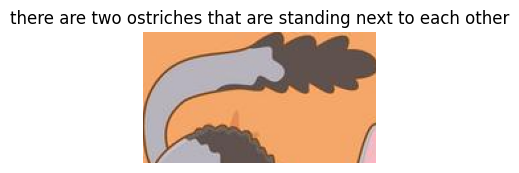

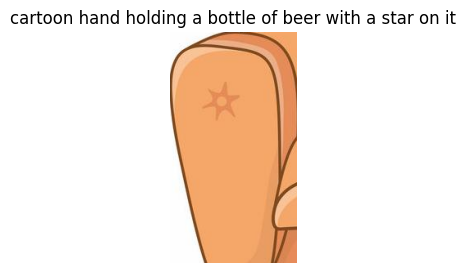

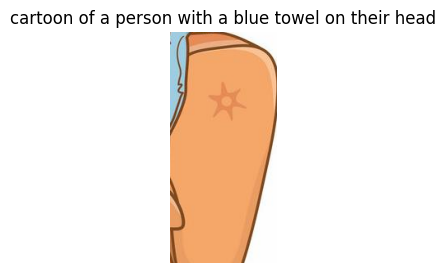

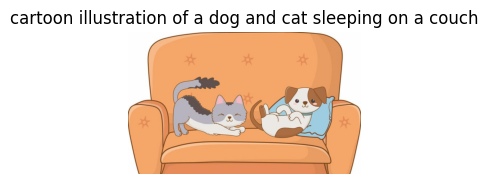

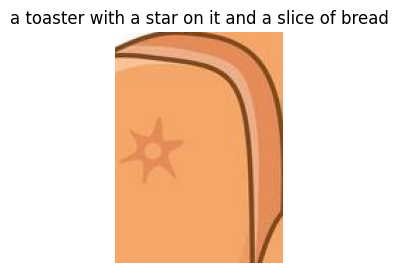

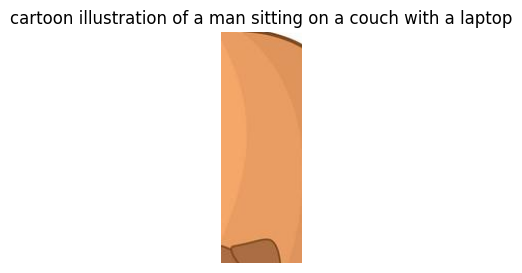

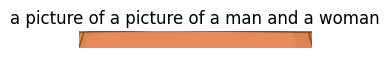

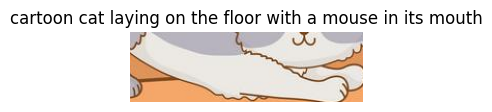

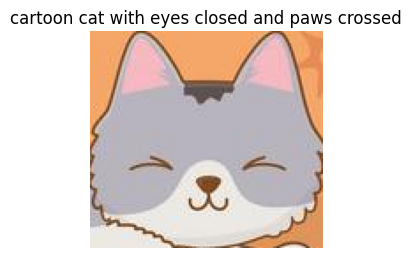

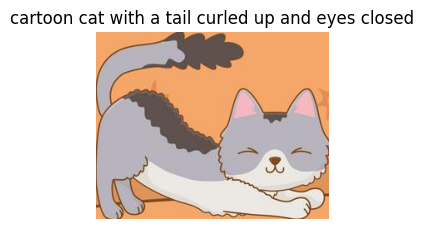

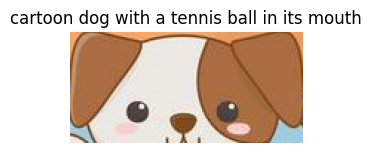

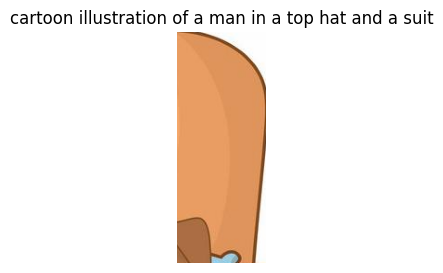

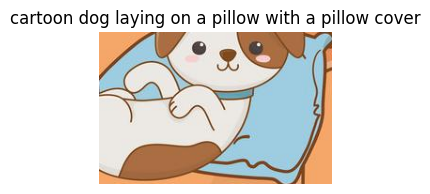

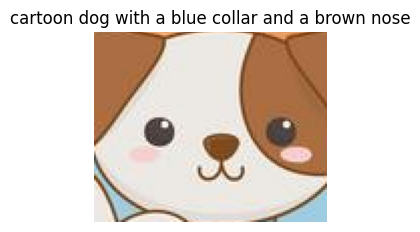

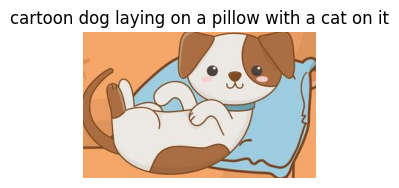

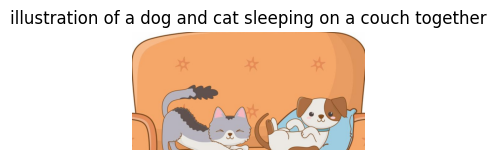

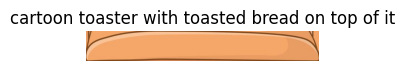

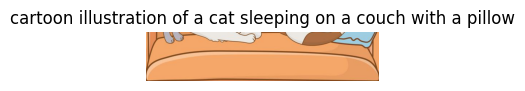

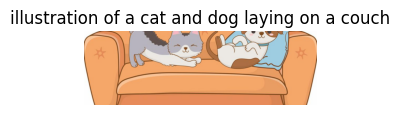

In [45]:
weigth, heigth = raw_image.size
area = (weigth * heigth)/image_partition
images = all_areas_from_image(image, raw_image, min_box_area = area)['box']
print(len(images))
for im in images:
    plt.figure(figsize=(3,3))
    plt.title(blip(im))
    plt.imshow(im)
    plt.axis('off')
    plt.show()